# Preprocessing

In [12]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rasterio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data loading

In [13]:
%cd '/content/drive/My Drive/sotiris/postgrad/semester2/geo/seira7/repo'
!pwd

/content/drive/My Drive/sotiris/postgrad/semester2/geo/seira7/repo
/content/drive/My Drive/sotiris/postgrad/semester2/geo/seira7/repo


In [14]:
import rasterio
import os
import numpy as np
import matplotlib.pyplot as plt

#normalisation function for each band separately
normalise = lambda x : x / np.max(x)

# Dioni
# read
dioni = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TrainingSet', 'Dioni.tif')).read()
#normalise
dioni = np.array(list(map(normalise, [dioni[i, :, :] for i in range(dioni.shape[0])])))
# view shape
print(dioni.shape)

# Dioni GT
dioni_gt = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TrainingSet', 'Dioni_GT.tif')).read()
print(dioni_gt.shape)

# Loukia
loukia = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TrainingSet', 'Loukia.tif')).read()
loukia = np.array(list(map(normalise, [loukia[i, :, :] for i in range(loukia.shape[0])])))
print(loukia.shape)

# Loukia GT
loukia_gt = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TrainingSet', 'Loukia_GT.tif')).read()
print(loukia_gt.shape)

# Erato
erato = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TestSet', 'Erato.tif')).read()
erato = np.array(list(map(normalise, [erato[i, :, :] for i in range(erato.shape[0])])))
print(erato.shape)

#  Kirki
kirki = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TestSet', 'Kirki.tif')).read()
kirki = np.array(list(map(normalise, [kirki[i, :, :] for i in range(kirki.shape[0])])))
print(kirki.shape)

# Nefeli
nefeli = rasterio.open(os.path.join(os.pardir, 'data', 'HyRANK_satellite', 'TestSet', 'Nefeli.tif')).read()
nefeli = np.array(list(map(normalise, [nefeli[i, :, :] for i in range(nefeli.shape[0])])))
print(nefeli.shape)

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(176, 250, 1376)
(1, 250, 1376)
(176, 249, 945)
(1, 249, 945)
(176, 241, 1632)
(176, 245, 1626)
(176, 249, 772)


# Data preparation for patch based classification

### Batch cropping functions
Combines padding where necessary along with square cropping of variable size around labeled pixels. This process creates a new image training set which provides a patch-based classification method for each labeled pixel. Every patch will be classified according to the label of its central pixel.

In [15]:
def crop_around_pixel(img, y, x, size=5):
    startx = x - size//2
    starty = y - size//2
    return img[:, starty:starty+size, startx:startx+size]

def labeled_pixels(gt):
  return np.argwhere(gt > 0)[:, [1, 2]]

def pad_image(img, padding):
    padded = np.zeros((img.shape[0], img.shape[1] + 2 * padding,
                      img.shape[2] + 2 * padding))
    padded[:, padding:-padding, padding:-padding] = img
    return padded

# function that creates tiles around label pixels of image
# will be used for supervised training only
def patches_supervised(img, gt, size=5):
    padding = size // 2
    img = pad_image(img, padding)
    coords = labeled_pixels(gt)
    patches = [crop_around_pixel(img, yx[0] + padding, yx[1] + padding, size) 
              for yx in coords]
    # supervised approach ignores 0 labels of unclassified pixels so -1
    labels =  np.asarray([gt[:, yx[0], yx[1]] - 1 for yx in coords], dtype="uint8") \
              .flatten()
    return patches, labels

# function that creates tiles around every pixel of image (unsupervised approach)
# will be used for inference and unsupervised pretraining
def patches_unsupervised(img, size=15):
    padding = size // 2
    img = pad_image(img, padding)
    coords = np.ndindex(img.shape[1], img.shape[2])
    patches = [crop_around_pixel(img, yx[0] + padding, yx[1] + padding, size) 
              for yx in coords]
    return patches, coords

### Demonstration of batch cropping

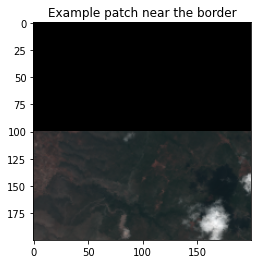

Label of this example patch:  8  =  Dense Sclerophyllous Vegetation
All existing labels:  [ 0  1  2  3  4  6  8  9 10 11 12 13]


In [16]:
patches, labels = patches_supervised(dioni, dioni_gt, 200)
patch_composite = patches[0][[23, 11, 7], :, :]
plt.imshow(patch_composite.transpose(1,2,0))
plt.title("Example patch near the border")
plt.show()
label_names = ["Dense Urban Fabric", "Mineral Extraction Sites", 
               "Non irrigated arable land", "Fruit trees", "Olive Groves", 
               "Broad leaved forest", "Coniferous Forest", "Mixed forest", 
               "Dense Sclerophyllous Vegetation", 
               "Sparse Sclerophyllous Vegetation", "Sparsely Vegetated Areas", 
               "Rocks and Sand", "Water", "Coastal Water"]
print("Label of this example patch: ", labels[0], " = ", label_names[labels[0]])
print("All existing labels: ", np.unique(labels))

### Training tools

In [17]:
import numpy as np
import torch
from sklearn import metrics
import os
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import classification_report

def logit_accuracy(logits, y_true):
    """This function computes the accuracy based on the logit outputs
    of the neural network (tensor) and the true y labels in integer form"""
    max_vals, y_pred = torch.max(logits, 1)
    acc = (y_pred == y_true).sum().item()/y_pred.size()[0]
    return acc, y_pred


def trainNN(model, model_folder_name, max_epochs, trainloader, valloader, 
            testloader, lr, transform, optimizer, criterion, patience=30,
            device="cpu", y_limit=0, save_to=None, regularizer=0):
    """This function trains a neural network (model) and then plot the loss
    diagrams on the training and validation sets through the epochs """ 

    # File and folder settings
    if save_to:
      save_to = str(os.path.join(save_to, model_folder_name)) 
      now = datetime.datetime.now() + datetime.timedelta(hours=3) 
      fname = str(now.strftime("%Y%m%d-%H%M%S"))
      os.makedirs(os.path.join(save_to, fname))
    
    # Initialisations
    epoch = 0
    epoch_loss_val = []
    epoch_acc_val = []
    epoch_loss_test = []
    epoch_acc_test = []
    epoch_loss_train = []
    epoch_acc_train = []
    countdown = patience    

    # Training
    while epoch < max_epochs and countdown > 0:
        # Training
        epoch +=1
        batch_loss = []
        y_pred = []
        batch_acc = []
        model.train()
        # enumerate fetches a batch of the data for training!
        for i, data in enumerate(trainloader):
            # assign batched X,y to variables
            inputs = data['tensors'].float().to(device)
            labels = data['labels'].long().to(device)

            # reset gradients for each batch
            # if we have different learning rates for the different parts of the
            # NN then a list of optimizers is fed to the function
            if type(optimizer) is list:
                [optimizer[i].zero_grad() for i in range(len(optimizer))]
            else:
                optimizer.zero_grad()
            # forward step
            logits = model(inputs)
            # compute loss and save it to list
            loss = criterion(logits, labels) + regularizer * model.l2_loss() if \
                   regularizer > 0 else criterion(logits, labels)
            batch_loss.append(loss.item())
            # backpropagate the loss
            loss.backward()
            ## update weights according to the selected optimizer
            # if we have different learning rates for the different parts of the
            # NN then a list of optimizers is fed to the function
            if type(optimizer) is list:
                [optimizer[i].step() for i in range(len(optimizer))]
            else:
                optimizer.step()
            # calculate batch accuracy for this epoch
            batch_acc.append(logit_accuracy(logits, labels)[0])
        print("Epoch {}\n===============\nTraining loss  : {:.4f}, Training accuracy  : {:.4f}".
            format(epoch, np.mean(batch_loss), np.mean(batch_acc)))
        # store each epochs performances for latter processing and plots
        epoch_loss_train.append(np.mean(batch_loss))
        epoch_acc_train.append(np.mean(batch_acc))
        
        # Validation
        batch_loss_val = []
        batch_acc_val = []
        y_pred_val = []
        y_val=[]
        
        # Validation
        #model.eval()
        # no need to store gradients here (Validation purposes only)
        with torch.no_grad():
            for i, data in enumerate(valloader):
                inputs = data['tensors'].float().to(device)
                labels = data['labels'].long().to(device)
                logits = model(inputs.float())
                loss_val = criterion(logits, labels)
                batch_loss_val.append(loss_val.item())
                batch_acc, batch_pred = logit_accuracy(logits, labels)
                batch_acc_val.append(batch_acc)
                y_pred_val.append(batch_pred)
                y_val.append(data['labels'])
        epoch_loss_val.append(np.mean(batch_loss_val))
        epoch_acc_val.append(np.mean(batch_acc_val))
        print("Validation loss: {:1.4f}, Validation accuracy: {:1.4f}".
              format(epoch_loss_val[-1], epoch_acc_val[-1]))
        y_pred_val = np.concatenate([y_pred_val[i].to("cpu").numpy()
                            for i in range(len(y_pred_val))]).reshape(-1)
        y_val = np.concatenate([y_val[i].to("cpu").numpy() 
                            for i in range(len(y_val))]).reshape(-1)
        labels = list(y_val)
        clval = classification_report(y_val, y_pred_val, digits=3) 
        
        #Test
        batch_loss_test = []
        batch_acc_test = []
        y_pred_test = []
        y_test = []
        with torch.no_grad():
            for i, data in enumerate(testloader):
                inputs = data['tensors'].float().to(device)
                labels = data['labels'].long().to(device)
                logits = model(inputs.float())
                loss_test = criterion(logits, labels)
                batch_loss_test.append(loss_test.item())
                batch_acc, batch_pred = logit_accuracy(logits, labels)
                batch_acc_test.append(batch_acc)
                y_pred_test.append(batch_pred)
                y_test.append(data['labels'])
        epoch_loss_test.append(np.mean(batch_loss_test))
        epoch_acc_test.append(np.mean(batch_acc_test))
        print("Test loss      : {:1.4f}, Test accuracy      : {:1.4f}\n".
              format(epoch_loss_test[-1], epoch_acc_test[-1]))
        y_pred_test = np.concatenate([y_pred_test[i].to("cpu").numpy()
                            for i in range(len(y_pred_test))]).reshape(-1)
        y_test = np.concatenate([y_test[i].to("cpu").numpy() 
                            for i in range(len(y_test))]).reshape(-1)
        labels = list(y_test)
        cltest = classification_report(y_val, y_pred_val, digits=3) 

         # early stopping
        print("Countdown: {}\n".format(countdown))
        if epoch_loss_val[-1] <= min(epoch_loss_val):
            countdown = patience #start countdown
            if save_to:
              #Checkpoint: I ovewrite models so as to keep the last to trigger the countdown
              torch.save(model, os.path.join(save_to, fname, "checkpoint" + ".pt"))
        else:
            countdown -= 1
    print("Finished Training!") 
    # results to files and pics
    if save_to:
      f = open(os.path.join(save_to, fname, fname + ".txt"), "a+")
      f.write("Convolutional:\n"+ str(model.conv_features)+"\n\n"+
              "Classifier:\n"+ str(model.classifier)+"\n\n"+ 
              "Learning rate: "+ str(lr) + "\n\n" +
              "L2 regularizer: "+ str(regularizer) + "\n\n" +
              "Transforms applied:\n\n"+ str(transform) + "\n\n")
      f.write("Validation Classification Report(last epoch): \n\n {}\n\n".format(clval))
      f.write("Test Classification Report(last epoch): \n\n {}".format(clval))
      f.close()
    plt1 = plots(epoch_loss_train, epoch_loss_val, epoch_loss_test, 
                 metric="loss", save_to=os.path.join(save_to, fname, fname),
                 epoch=epoch, y_limit=y_limit)
    plt2 = plots(epoch_acc_train, epoch_acc_val, epoch_acc_test, 
                 metric="accuracy", save_to=os.path.join(save_to, fname, fname),
                 epoch=epoch, y_limit=y_limit)
    return
# Plot Train / Validation / Test Loss and Acc
import numpy as np
def plots(train, val, test, save_to, epoch, y_limit, metric="loss"):
    plt.rcParams["figure.figsize"] = (10,4)
    plt.figure()
    plt.title("Relative"+str(metric))
    plt.plot(list(range(1, epoch + 1)), train, label='Training set')
    plt.plot(list(range(1, epoch + 1)), val,  label='Validation set')
    plt.plot(list(range(1, epoch + 1)), test,  label='Validation set')
    if metric == "loss":
      plt.scatter(np.argmin(np.array(val))+1, 
                  min(val), color="red", label="Minimum validation loss")
      plt.scatter(np.argmin(np.array(test))+1, 
                  min(test), color="green", label="Minimum test loss")
    # max val accuracy point
    else:
      maxaccv=max(val)
      plt.scatter(np.argmax(np.array(val))+1, 
                 maxaccv, color="red", label="Maximum validation accuracy="+
                 str(np.around(maxaccv,3)))
    # max test accuracy point
      maxacct = max(test)
      plt.scatter(np.argmax(np.array(test))+1, 
                  maxacct, color="green", label="Maximum test accuracy="+
                  str(np.around(maxacct,3)))
    plt.grid()
    if y_limit==0:
      y_limit = 0.6 if metric=="loss" else 1.0
    else:
      y_limit = y_limit if metric=="loss" else 1.0
    plt.ylim(0, y_limit)
    plt.legend(fancybox=True)
    if save_to:
      plt.savefig(save_to + "_" + str(metric) + ".png")
    plt.show()

### Model

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class myDeepCNN(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()
        
        # set depth
        self.depth = 2

        # convolutional layers
        self.conv_features_1 = nn.Sequential(
        # first convolutional set of layers
            nn.Conv2d(in_channels=176, out_channels=128, kernel_size=3, padding=1),  
            nn.BatchNorm2d(num_features=128),  
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),   
            nn.BatchNorm2d(num_features=64),  
            nn.ReLU(inplace=True))
        
        self.conv_features_2 = nn.Sequential(
          # second convolutional set of layers
            nn.Conv2d(64, 64, 3, padding=1), 
            nn.BatchNorm2d(64))
        
        self.conv_features_3 = nn.Sequential(
          #bottleneck layer to reduce size to be fed to classifier
            nn.Conv2d(64, 32, 5, padding=2),
            nn.MaxPool2d(3,1),             
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3), 
            nn.MaxPool2d(3,2),             
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 1), 
            nn.MaxPool2d(3,1),             
            nn.ReLU(inplace=True))
        
        self.classifier = nn.Sequential(
          nn.Flatten(),
          # size imposed by adaptive pooling
          nn.Linear(288, 256),
          nn.Linear(256, num_classes))
        
        self.conv_features = str(self.depth)+"-skip connected layer"

    def forward(self, x):
        x = self.conv_features_1(x)
        x = self.conv_features_2(x)
        residual = x.clone()
        # skip connection 1
        for i in range(self.depth):
            x = self.conv_features_2(x)
            x, residual = self.skip_connection(x, residual)
        x = self.conv_features_2(x)
        x = self.conv_features_3(x)
        x = self.classifier(x)
        return x

    def skip_connection(self, x, residual):
        x += residual
        # Relu needs to be after the skip connection addition
        x = F.relu(x)
        residual = x.clone()
        return x, residual


class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

class CNN(nn.Module):
    def __init__(self, image_channels=176, h_dim=128, z_dim=32, num_classes=14):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 256, kernel_size=4, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=4, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            Flatten()
            )
        
        self.conv_features = str(self.encoder)

        self.classifier = nn.Sequential(
          nn.Flatten(),
          # size imposed by adaptive pooling
          nn.Linear(128, 64),
          nn.Linear(64, num_classes))
        
        # self.fc1 = nn.Linear(h_dim, h_dim//2)
        # self.fc2 = nn.Linear(h_dim//2, z_dim)
        # self.fc3 = nn.Linear(z_dim, h_dim//2)
        # self.fc4 = nn.Linear(h_dim//2, )
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 512, kernel_size=5, stride=2),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=6, stride=2),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        

    def encode(self, x):
        h = self.encoder(x)
        return h

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z = self.encode(x)
        z = self.classifier(z)
        #z = self.decode(z)
        return z

# class CNN(nn.Module):
#     def __init__(self, image_channels=176, h_dim=128, z_dim=32):
#         super(CNN, self).__init__()
#     def forward(self, x):
#       pass

### CUDA

In [19]:
import torch

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.empty_cache()
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


### Transformations

In [20]:
import os
import random
from scipy import ndarray
from scipy import ndimage
import skimage as sk
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-40, 40)
    return ndimage.rotate(input=image_array, angle=random_degree, axes=(1,2),
                          reshape=False)

def random_noise(image_array: ndarray):
    # add a bit of random noise to the image
    return sk.util.random_noise(image_array, mode="gaussian", mean=0, var=0.0001)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, :, ::-1]

def vertical_flip(image_array: ndarray):
    # vertical flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1, :]

# dictionary of the transformations we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip,
    'vertical_flip': vertical_flip,
    'No': lambda x : x
}

### Dataset

In [21]:
from torch.utils.data import Dataset

class HyRank(Dataset):
    def __init__(self, X, y, transform=False, supervision=True):
        self.supervision = supervision
        self.transform = transform
        self.labels = y
        self.patches = X
            
    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        if self.supervision:
            if self.transform:
              key = random.choice(list(self.transform.keys()))
              return {'tensors': self.transform[key](self.patches[idx]).copy(),
                      'labels': self.labels[idx]}
            else:
              return {'tensors': self.patches[idx],
                      'labels': self.labels[idx]}
        else:
            if self.transform:
              key = random.choice(list(self.transform.keys()))
              return {'tensors': self.transform[key](self.patches[idx]).copy(),
                      'labels': self.transform[key](self.patches[idx]).copy()}
            else:
              return {'tensors': self.patches[idx],
                      'labels': self.patches[idx]}


### Settings and hyperparameters


In [22]:
# Set hyperparameters here

# train / val / test splits ratio
train_val_test_ratio=[0.7, 0.15, 0.15]

# set patch size
patch_size = 15

# set batch size
batch = 128

# select model here
selected_model = "skip_CNN" 
models = {"skip_CNN": myDeepCNN(), "AE_enc": CNN()} # , "AE": AE()}

model = models[selected_model].to(device)

# Location to save models
save_to = "/content/drive/My Drive/sotiris/postgrad/semester2/geo/seira7/results"

# Patience to stop training after best model
patience = 40

# lr and regularization
lr = 0.003
regularizer = 0 

### Train / Test split
In this section, patches of selected dimensions are created and split into train / test / validation sets. Firstly, it is essential to set exclusive subsets of each image to functions as banks of train / test / validation patches so that the respective patches are prevented from overlaps. Overlaps mean cheating that is bad generalisation to the test images. It was considered preferable to split the images horizontally given that such a split retains in the best possible degree the existence of all classes in each set.

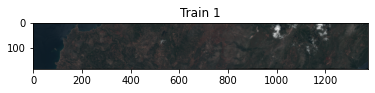

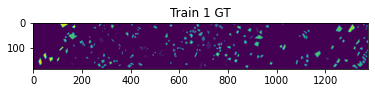

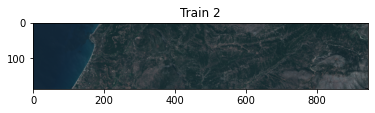

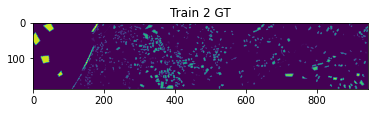

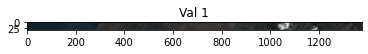

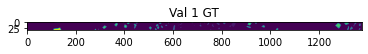

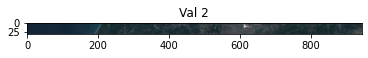

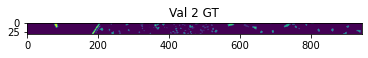

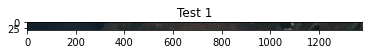

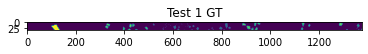

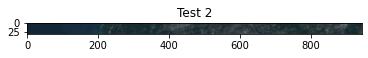

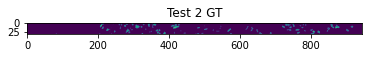

In [23]:
train = [dioni[:, dioni.shape[1]//4:, :], loukia[:, loukia.shape[1]//4:, :]]

val = [dioni[:, dioni.shape[1]//8:dioni.shape[1]//4, :], 
         loukia[:, loukia.shape[1]//8:loukia.shape[1]//4, :]]

test = [dioni[:, :dioni.shape[1]//8, :], 
         loukia[:, :loukia.shape[1]//8, :]]

train_gt = [dioni_gt[:, dioni_gt.shape[1]//4:, :], loukia_gt[:, loukia_gt.shape[1]//4:, :]]

val_gt = [dioni_gt[:, dioni_gt.shape[1]//8:dioni_gt.shape[1]//4, :], 
         loukia_gt[:, loukia_gt.shape[1]//8:loukia_gt.shape[1]//4, :]]

test_gt = [dioni_gt[:, :dioni_gt.shape[1]//8, :], 
         loukia_gt[:, :loukia_gt.shape[1]//8, :]]

dioni_composite = train[0][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Train 1")
plt.show()

dioni_composite = train_gt[0][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Train 1 GT")
plt.show()

dioni_composite = train[1][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Train 2")
plt.show()

dioni_composite = train_gt[1][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Train 2 GT")
plt.show()

dioni_composite = val[0][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Val 1")
plt.show()

dioni_composite = val_gt[0][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Val 1 GT")
plt.show()

dioni_composite = val[1][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Val 2")
plt.show()

dioni_composite = val_gt[1][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Val 2 GT")
plt.show()

dioni_composite = test[0][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Test 1")
plt.show()

dioni_composite = test_gt[0][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Test 1 GT")
plt.show()

dioni_composite = test[1][[23, 11, 7], :, :]
plt.imshow(dioni_composite.transpose(1,2,0))
plt.title("Test 2")
plt.show()

dioni_composite = test_gt[1][:, :, :].squeeze(0)
plt.imshow(dioni_composite)
plt.title("Test 2 GT")
plt.show()

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test= []
coords = []

if selected_model  != "AE":

  criterion = torch.nn.CrossEntropyLoss().to(device)

  # patch training set
  for (img, gt) in zip(train, train_gt):
      patch, label = patches_supervised(img=img, gt=gt, size=patch_size)
      X_train.extend(patch)
      y_train.extend(label)

    # patch training set
  for (img, gt) in zip(val, val_gt):
      patch, label = patches_supervised(img=img, gt=gt, size=patch_size)
      X_val.extend(patch)
      y_val.extend(label)

    # patch training set
  for (img, gt) in zip(test, test_gt):
      patch, label = patches_supervised(img=img, gt=gt, size=patch_size)
      X_test.extend(patch)
      y_test.extend(label)
  
else: # unsupervised = self supervised pretraining
  
  supervision = False

  # criterion = ?????
  
  for img in train:
  # I keep the coords so as to know which pixel I infer every time
    patch, coord_set = patches_unsupervised(img=img, size=patch_size)
    X_train.extend(patch)
    coords.extend(coord_set)

### Dataloaders and patch demonstration

torch.Size([128, 176, 15, 15])


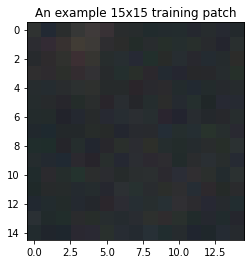

torch.Size([128, 176, 15, 15])


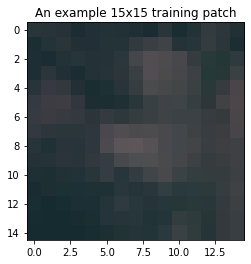

torch.Size([128, 176, 15, 15])


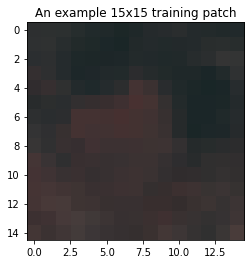

torch.Size([128, 176, 15, 15])


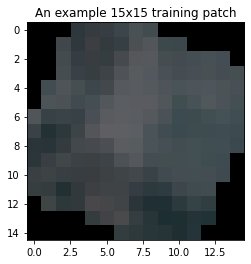

torch.Size([128, 176, 15, 15])


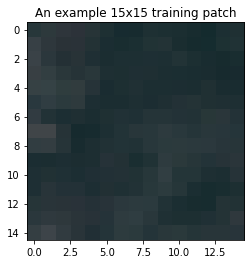

In [24]:
## Dataset
train = HyRank(X=X_train, y=y_train, transform=available_transformations)
val = HyRank(X=X_val, y=y_val, transform=available_transformations)
test = HyRank(X=X_test, y=y_test, transform=available_transformations)
# Dataloaders
from torch.utils.data import DataLoader
trainloader = DataLoader(train, batch_size=batch, num_workers=0, shuffle=True)
valloader = DataLoader(val, batch_size=batch, num_workers=0, shuffle=False)
testloader = DataLoader(test, batch_size=batch, num_workers=0, shuffle=False)

# Demo
i=0
for i, data in enumerate(trainloader):
    i+=1
    print(data["tensors"].shape)
    composite = data["tensors"][-1, [23, 11, 7], :, :].squeeze(0)
    plt.imshow(composite.numpy().transpose(1,2,0))
    plt.title("An example " + str(patch_size) + "x" + str(patch_size) + 
              " training patch")
    plt.show()
    if i==5:
      break

### Training

In [25]:
torch.cuda.empty_cache()
model.train()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training
trainNN(model=model, patience=patience, model_folder_name=selected_model,
        max_epochs=250, trainloader=trainloader, valloader=valloader, 
        testloader=testloader,device=device, optimizer=optimizer, 
        criterion=criterion, lr=lr, transform=available_transformations,
        save_to=save_to, y_limit=3)

KeyboardInterrupt: ignored

# Extra modelz